In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/'My Drive'/'All_Repos'/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/All_Repos/Self-Driving-Car-NanoDegree/CarND-Traffic-Sign-Classifier-Project


In [2]:
!ls dataset

augmented_train.p  signnames.csv.gsheet  traffic-signs-data.zip  valid.p
signnames.csv	   test.p		 train.p


## Load the Data

In [0]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'dataset/train.p'
validation_file= 'dataset/valid.p'
testing_file = 'dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
import numpy as np


### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = y_train.shape[0]

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


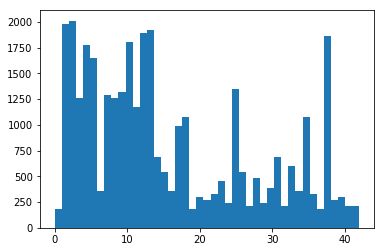

[ 180 1980 2010 1260 1770 1650  360 1290 1260 1320 1800 1170 1890 1920
  690  540  360  990 1080  180  300  270  330  450  240 1350  540  210
  480  240  390  690  210  599  360 1080  330  180 1860  270  300  210
  210]


In [5]:
import matplotlib.pyplot as plt
plt.hist(y_train,bins=43)
plt.show()

uniques,counts = np.unique(y_train,return_counts=True)

print(counts)

## Exploratory Visualization

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

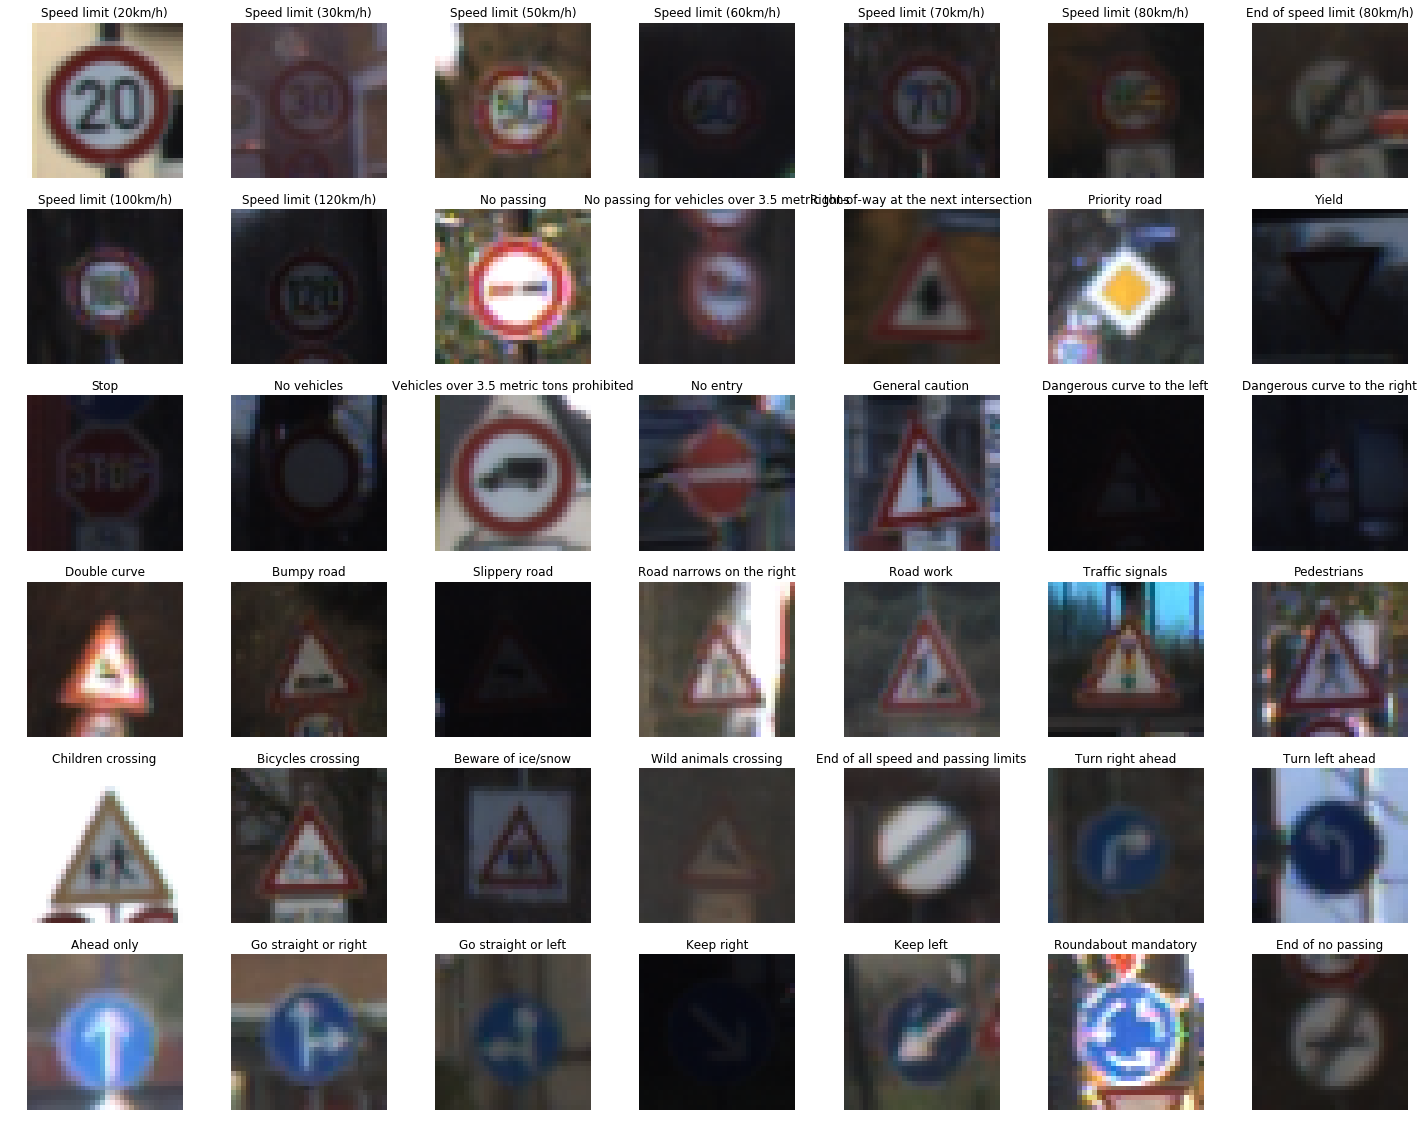

In [6]:
import pandas as pd



names = pd.read_csv('dataset/signnames.csv')
names.set_index(['ClassId'],inplace=True)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(6, 7, figsize=(25, 20))
count = 0

for i in range(6):
  for j in range(7):
    axs[i][j].imshow(X_train[np.where(y_train == count)[0][0]])
    #print(names.loc[5].SignName)
    axs[i][j].set_title(names.loc[count].SignName)
    axs[i][j].set_axis_off()
    count+=1

plt.show()

## Read Dump File

```
# This is formatted as code
```



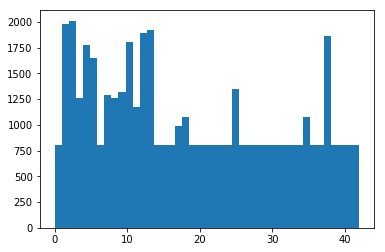

In [7]:
import matplotlib.pyplot as plt
with open('dataset/augmented_train.p', mode='rb') as f:
    aug_dataset = pickle.load(f)
X_train = aug_dataset['X_train']
y_train = aug_dataset['y_train']

#print(X_train.shape,y_train.shape)
plt.hist(y_train,bins=43)
plt.show()



In [8]:
import cv2
def normalize_gray(images):
  result = np.zeros((len(images), 32, 32, 1), np.float64)
  
  for i,image in enumerate(images):
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    result[i] = ((gray.astype(float) -128./ 128.)).reshape(32,32,1)
  return result.astype('uint8')

def normalize(images):
  result = np.zeros((len(images), 32, 32, 3), np.float64)
  
  for i,image in enumerate(images):
    result[i] = ((image.astype(float) -128. /128.)).reshape(32,32,3)
  return result.astype('uint8')

X_train_new = normalize(X_train)
X_valid_new = normalize(X_valid)
X_test_new = normalize(X_test)
print(X_train_new.shape)

(46507, 32, 32, 3)


In [0]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)


EPOCHS = 175
BATCH_SIZE = 128


def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    FF_W0 = tf.Variable(tf.truncated_normal((5, 5, 3, 16), mean = mu, stddev = sigma))
    FF_B0 = tf.Variable(tf.zeros(16))
    conv_1 = tf.nn.conv2d(x, FF_W0, [1,1,1,1], padding='VALID') + FF_B0
    # TODO: Activation.
    conv_1 = tf.nn.relu(conv_1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x16.
    conv_1 = tf.nn.max_pool(conv_1, [1,2,2,1],[1,2,2,1], padding='VALID')
    # TODO: Layer 2: Convolutional. Output = 10x10x32.
    FF_W1 = tf.Variable(tf.truncated_normal((5, 5, 16, 32), mean = mu, stddev = sigma))
    FF_B1 = tf.Variable(tf.zeros(32))
    conv_2 = tf.nn.conv2d(conv_1, FF_W1, [1,1,1,1], padding='VALID') + FF_B1
    # TODO: Activation.
    conv_2 = tf.nn.relu(conv_2)
    # TODO: Pooling. Input = 10x10x32. Output = 5x5x32.
    conv_2 = tf.nn.max_pool(conv_2, [1,2,2,1],[1,2,2,1], padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 800.
    flatten_1 = tf.contrib.layers.flatten(conv_2)
    
    # TODO: Layer 3: Fully Connected. Input = 800. Output = 240.
    FF_W2 = tf.Variable(tf.truncated_normal((800,240), mean = mu, stddev = sigma))
    FF_B2 = tf.Variable(tf.zeros(240))
    dense_1 = tf.add(tf.matmul(flatten_1,FF_W2),FF_B2)
    # TODO: Activation.
    dense_1 = tf.nn.relu(dense_1)
    # Dropout
    dropped_1 = tf.nn.dropout(dense_1,keep_prob)
    
    # TODO: Layer 4: Fully Connected. Input = 240. Output = 84.
    flatten_2 = tf.contrib.layers.flatten(dropped_1)
    FF_W3 = tf.Variable(tf.truncated_normal((240,84), mean = mu, stddev = sigma))
    FF_B3 = tf.Variable(tf.zeros(84))
    dense_2 = tf.add(tf.matmul(flatten_2,FF_W3),FF_B3)
    # TODO: Activation.
    dense_2 = tf.nn.relu(dense_2)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    flatten_3 = tf.contrib.layers.flatten(dense_2)
    FF_W4 = tf.Variable(tf.truncated_normal((84,43), mean = mu, stddev = sigma))
    FF_B4 = tf.Variable(tf.zeros(43))
    dense_3 = tf.add(tf.matmul(flatten_3,FF_W4),FF_B4)
    
    regularizers = tf.nn.l2_loss(FF_W0) + tf.nn.l2_loss(FF_W1) \
                   + tf.nn.l2_loss(FF_W2) + tf.nn.l2_loss(FF_W3) \
                   + tf.nn.l2_loss(FF_W4)
    return dense_3,regularizers

In [10]:
rate = 0.0006
beta = 0.001
#x = tf.image.per_image_standardization(x)


logits,regularizers = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy + beta * regularizers)
#loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


W0710 04:26:28.162314 140701506598784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/layers/python/layers/layers.py:1634: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0710 04:26:28.434186 140701506598784 deprecation.py:506] From <ipython-input-9-8064b3ad6771>:47: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0710 04:26:28.501347 140701506598784 deprecation.py:323] From <ipython-input-10-c766c1f25a7c>:7: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backp

In [0]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        #batch_x=tf_preprocess([x for x in batch_x])
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    validation_accuracy = []
    train_accuracy = []
    for i in range(EPOCHS):
        X_train_new, y_train = shuffle(X_train_new, y_train)
          
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_new[offset:end], y_train[offset:end]
            #batch_x=tf_preprocess([x for x in batch_x])
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob :0.5})
        train_accuracy.append(evaluate(X_train_new,y_train))    
        validation_accuracy.append(evaluate(X_valid_new, y_valid))
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy[i]))
        print()
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.055

EPOCH 2 ...
Validation Accuracy = 0.055

EPOCH 3 ...
Validation Accuracy = 0.080

EPOCH 4 ...
Validation Accuracy = 0.275

EPOCH 5 ...
Validation Accuracy = 0.494

EPOCH 6 ...
Validation Accuracy = 0.537

EPOCH 7 ...
Validation Accuracy = 0.612

EPOCH 8 ...
Validation Accuracy = 0.678

EPOCH 9 ...
Validation Accuracy = 0.781

EPOCH 10 ...
Validation Accuracy = 0.805

EPOCH 11 ...
Validation Accuracy = 0.844

EPOCH 12 ...
Validation Accuracy = 0.852

EPOCH 13 ...
Validation Accuracy = 0.883

EPOCH 14 ...
Validation Accuracy = 0.878

EPOCH 15 ...
Validation Accuracy = 0.885

EPOCH 16 ...
Validation Accuracy = 0.916

EPOCH 17 ...
Validation Accuracy = 0.917

EPOCH 18 ...
Validation Accuracy = 0.936

EPOCH 19 ...
Validation Accuracy = 0.927

EPOCH 20 ...
Validation Accuracy = 0.930

EPOCH 21 ...
Validation Accuracy = 0.930

EPOCH 22 ...
Validation Accuracy = 0.932

EPOCH 23 ...
Validation Accuracy = 0.939

EPOCH 24 ...
Validation Accura

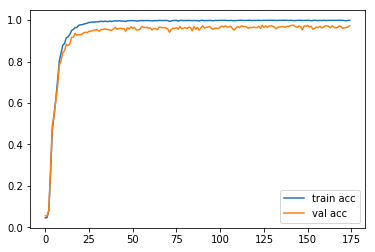

In [13]:
plt.plot(train_accuracy,label='train acc')

plt.plot(validation_accuracy, label='val acc')
plt.legend()
plt.show()

In [18]:
print("train accuracy = ",train_accuracy[174])
print("validation accuracy = ",validation_accuracy[174])

train accuracy =  0.9992474251187993
validation accuracy =  0.9732426301422032


In [19]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test_new, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))
    

Test Set Accuracy = 0.964


## Load and Preprocess Web Images


traffic_signs.jpg
23


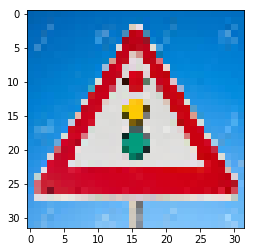

slippery.jpg
12


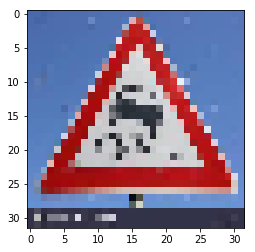

priority-road.jpg
14


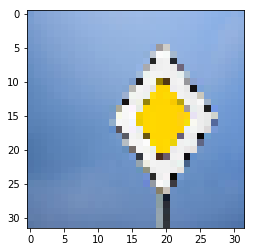

pedestrian.jpg
11


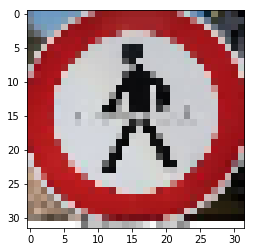

In [16]:
import os
import cv2

img_paths = os.listdir('./web_images')

images = list()
labels = np.array([23,12,14,11,15])
count=0
for im_pth in img_paths:
  print(im_pth)
  img = cv2.imread('web_images/'+im_pth)
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  #plt.imshow(img)
  img = cv2.resize(img,(32,32))
  print(labels[count])
  plt.imshow(img)
  plt.show()
  count+=1
  images.append(img)

images = np.array(images)


images = normalize(images)

In [17]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    top_k = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: images, y: labels, keep_prob: 1})
    
print(top_k)

TopKV2(values=array([[9.9999988e-01, 1.6120840e-07, 5.5237176e-11, 3.4499736e-12,
        1.4236272e-12],
       [9.6728867e-01, 2.7032956e-02, 5.5439649e-03, 1.3263270e-04,
        1.6247769e-06],
       [9.9771166e-01, 9.6529402e-04, 8.2601135e-04, 1.4934264e-04,
        9.4414419e-05],
       [6.0880679e-01, 2.5956464e-01, 1.2439434e-01, 5.3270990e-03,
        1.1407438e-03]], dtype=float32), indices=array([[26, 11, 22, 18, 14],
       [23, 19,  0, 24, 21],
       [12, 38,  0, 39, 33],
       [19, 15,  1,  4,  0]], dtype=int32))
